In [1]:
import jax 
jax.config.update('jax_platform_name', 'cpu')
import numpyro 
numpyro.set_host_device_count(4)

In [2]:
from pyprojroot import here
import sys
sys.path.insert(0, str(here()))

from laos_gggi import load_all_data
from laos_gggi.plotting import configure_plot_style
import arviz as az
import matplotlib.pyplot as plt

configure_plot_style(add_grid = True)

In [3]:
df = load_all_data()['df_time_series']

<Axes: xlabel='year'>

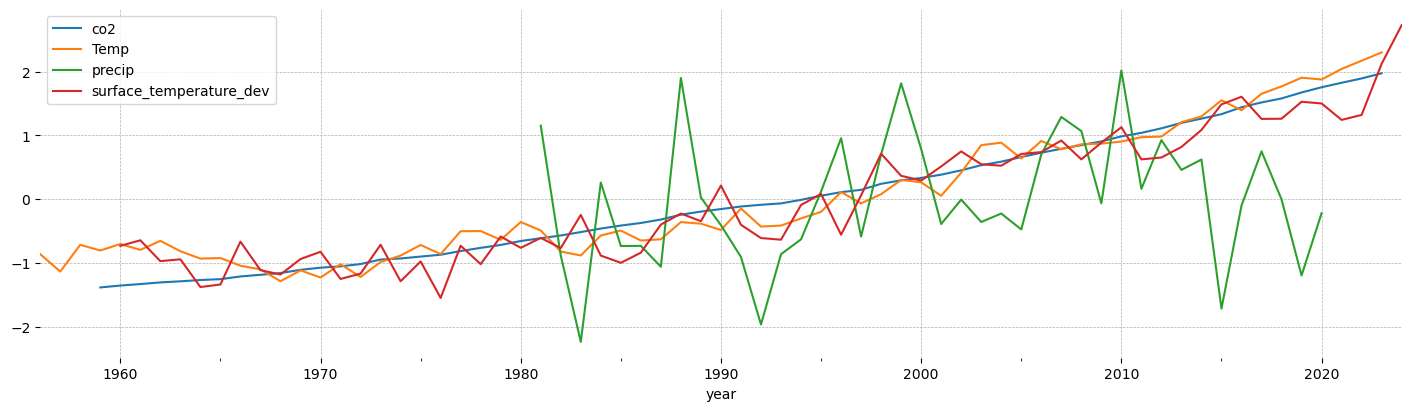

In [4]:
df = df.apply(lambda x: (x - x.mean()) / x.std())
df.index.freq = df.index.inferred_freq
df.plot()

# PyMC machinery

In [5]:
import pymc as pm
import pytensor.tensor as pt
from pymc_experimental import statespace as pmss

In [6]:
mod = pmss.BayesianETS(order=('A', 'Ad', 'N'), 
                      endog_names=df.columns.tolist(),
                      dense_innovation_covariance=True)

The following parameters should be assigned priors inside a PyMC model block: 
	initial_level -- shape: (4,), constraints: None, dims: ('observed_state',)
	initial_trend -- shape: (4,), constraints: None, dims: ('observed_state',)
	P0 -- shape: (12, 12), constraints: Positive Semi-definite, dims: ('state', 'state_aux')
	alpha -- shape: (4,), constraints: 0 < alpha < 1, dims: ('observed_state',)
	beta -- shape: (4,), constraints: 0 < beta < 1, dims: ('observed_state',)
	phi -- shape: (4,), constraints: 0 < phi < 1, dims: ('observed_state',)
	state_cov -- shape: (4, 4), constraints: Positive Semi-definite, dims: ('observed_state', 'observed_state_aux')


In [7]:
from itertools import combinations
coords = mod.coords.copy()
coords['state_corr_tril'] = [f'corr({x}, {y})' for x, y in combinations(mod.coords['observed_state'], 2)]

In [8]:
with pm.Model(coords = coords) as m:
    initial_level = pm.Normal('initial_level', dims = ('observed_state',))
    initial_trend = pm.Normal('initial_trend', dims = ('observed_state',))
    
    P0 = pm.Deterministic('P0', pt.eye(mod.k_states), dims = ('state', 'state_aux'))
    
    alpha = pm.Beta('alpha', 1, 1, dims = ('observed_state',))
    beta = pm.Beta('beta', 1, 1, dims = ('observed_state',))
    gamma = pm.Beta('gamma', 1, 1, dims = ('observed_state',))
    phi = pm.Beta('phi', 10, 1, dims = ('observed_state',))
    
    state_chol, state_corr, state_std = pm.LKJCholeskyCov('state_chol', n=mod.k_endog, eta=1, sd_dist=pm.Exponential.dist(1))
    
    state_corr = pm.Deterministic('state_corr', 
                                  state_corr[pt.tril_indices_from(state_corr, k=-1)],
                                 dims=['state_corr_tril'])
    state_cov = pm.Deterministic('state_cov', 
                                 state_chol @ state_chol.T, 
                                 dims = ('observed_state', 'observed_state_aux'))

    mod.build_statespace_graph(data=df, mode='JAX')
    idata = pm.sample(nuts_sampler='numpyro',
                      idata_kwargs={"dims": {"state_chol_stds": ["observed_state"], 
                                             "state_chol_corr": ['observed_state', 'observed_state_aux']}})

/Users/jessegrabowski/Documents/Python/pymc-experimental/pymc_experimental/statespace/utils/data_tools.py:159: ImputationWarning: Provided data contains missing values and will be automatically imputed as hidden states during Kalman filtering.
  warnings.warn(impute_message, ImputationWarning)
/Users/jessegrabowski/mambaforge/envs/laos-climate-change/lib/python3.12/functools.py:909: UserWarning: Skipping `CheckAndRaise` Op (assertion: PyTensor Assert failed!) as JAX tracing would remove it.
  return dispatch(args[0].__class__)(*args, **kw)
/Users/jessegrabowski/mambaforge/envs/laos-climate-change/lib/python3.12/functools.py:909: UserWarning: Skipping `CheckAndRaise` Op (assertion: PyTensor Assert failed!) as JAX tracing would remove it.
  return dispatch(args[0].__class__)(*args, **kw)


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

<Axes: >

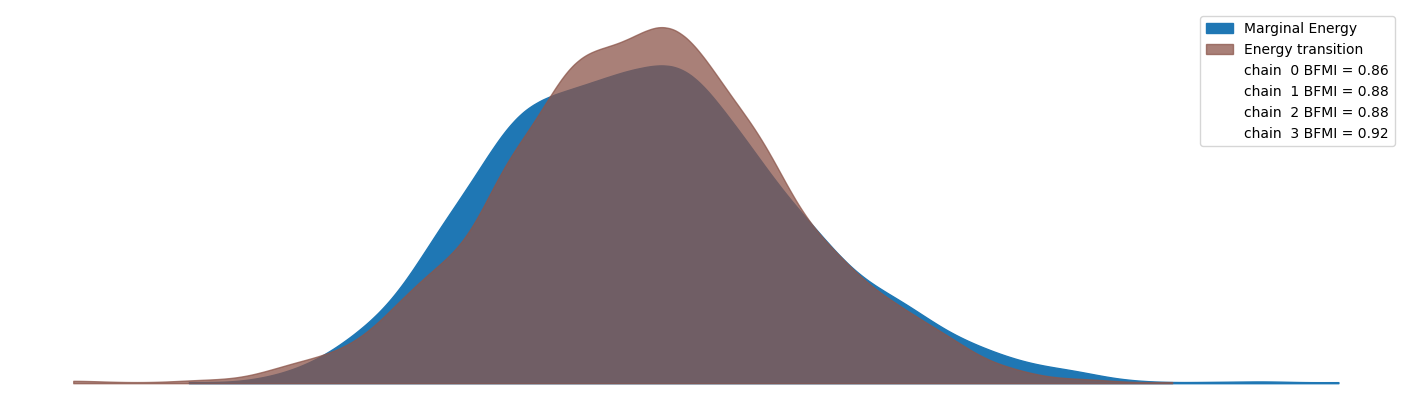

In [9]:
az.plot_energy(idata)

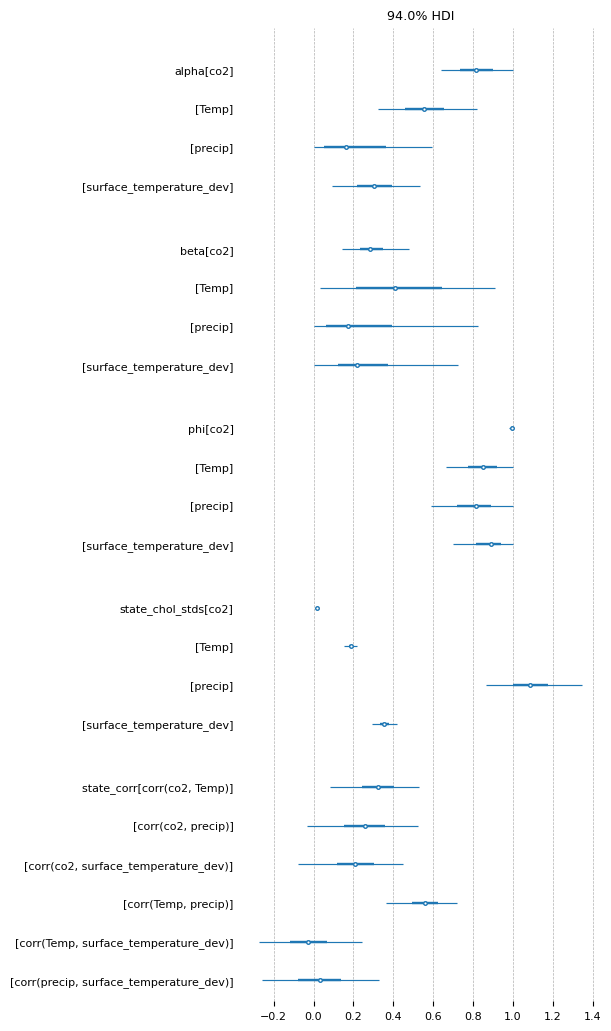

In [10]:
az.plot_forest(idata, var_names=['alpha', 'beta', 'phi', 'state_chol_stds', 'state_corr'], 
               combined=True,
               textsize=8);

In [11]:
idata_pred = mod.sample_conditional_posterior(idata)

/Users/jessegrabowski/Documents/Python/pymc-experimental/pymc_experimental/statespace/utils/data_tools.py:159: ImputationWarning: Provided data contains missing values and will be automatically imputed as hidden states during Kalman filtering.
  warnings.warn(impute_message, ImputationWarning)
/Users/jessegrabowski/mambaforge/envs/laos-climate-change/lib/python3.12/site-packages/pytensor/link/jax/linker.py:28: UserWarning: The RandomType SharedVariables [RNG(<Generator(PCG64) at 0x2B1BD9E00>), RNG(<Generator(PCG64) at 0x2B1BDA0A0>), RNG(<Generator(PCG64) at 0x2B1BDA7A0>), RNG(<Generator(PCG64) at 0x2B1BDB060>), RNG(<Generator(PCG64) at 0x2B1BDB140>), RNG(<Generator(PCG64) at 0x29C7451C0>)] will not be used in the compiled JAX graph. Instead a copy will be used.
  warnings.warn(
Sampling: [filtered_posterior, filtered_posterior_observed, predicted_posterior, predicted_posterior_observed, smoothed_posterior, smoothed_posterior_observed]


Output()

In [12]:
idata_forecast = mod.forecast(idata, start=df.index[-1], periods=30)

/Users/jessegrabowski/Documents/Python/pymc-experimental/pymc_experimental/statespace/utils/data_tools.py:159: ImputationWarning: Provided data contains missing values and will be automatically imputed as hidden states during Kalman filtering.
  warnings.warn(impute_message, ImputationWarning)
/Users/jessegrabowski/mambaforge/envs/laos-climate-change/lib/python3.12/site-packages/pytensor/link/jax/linker.py:28: UserWarning: The RandomType SharedVariables [RNG(<Generator(PCG64) at 0x29CB48200>)] will not be used in the compiled JAX graph. Instead a copy will be used.
  warnings.warn(
Sampling: [forecast_combined]


Output()

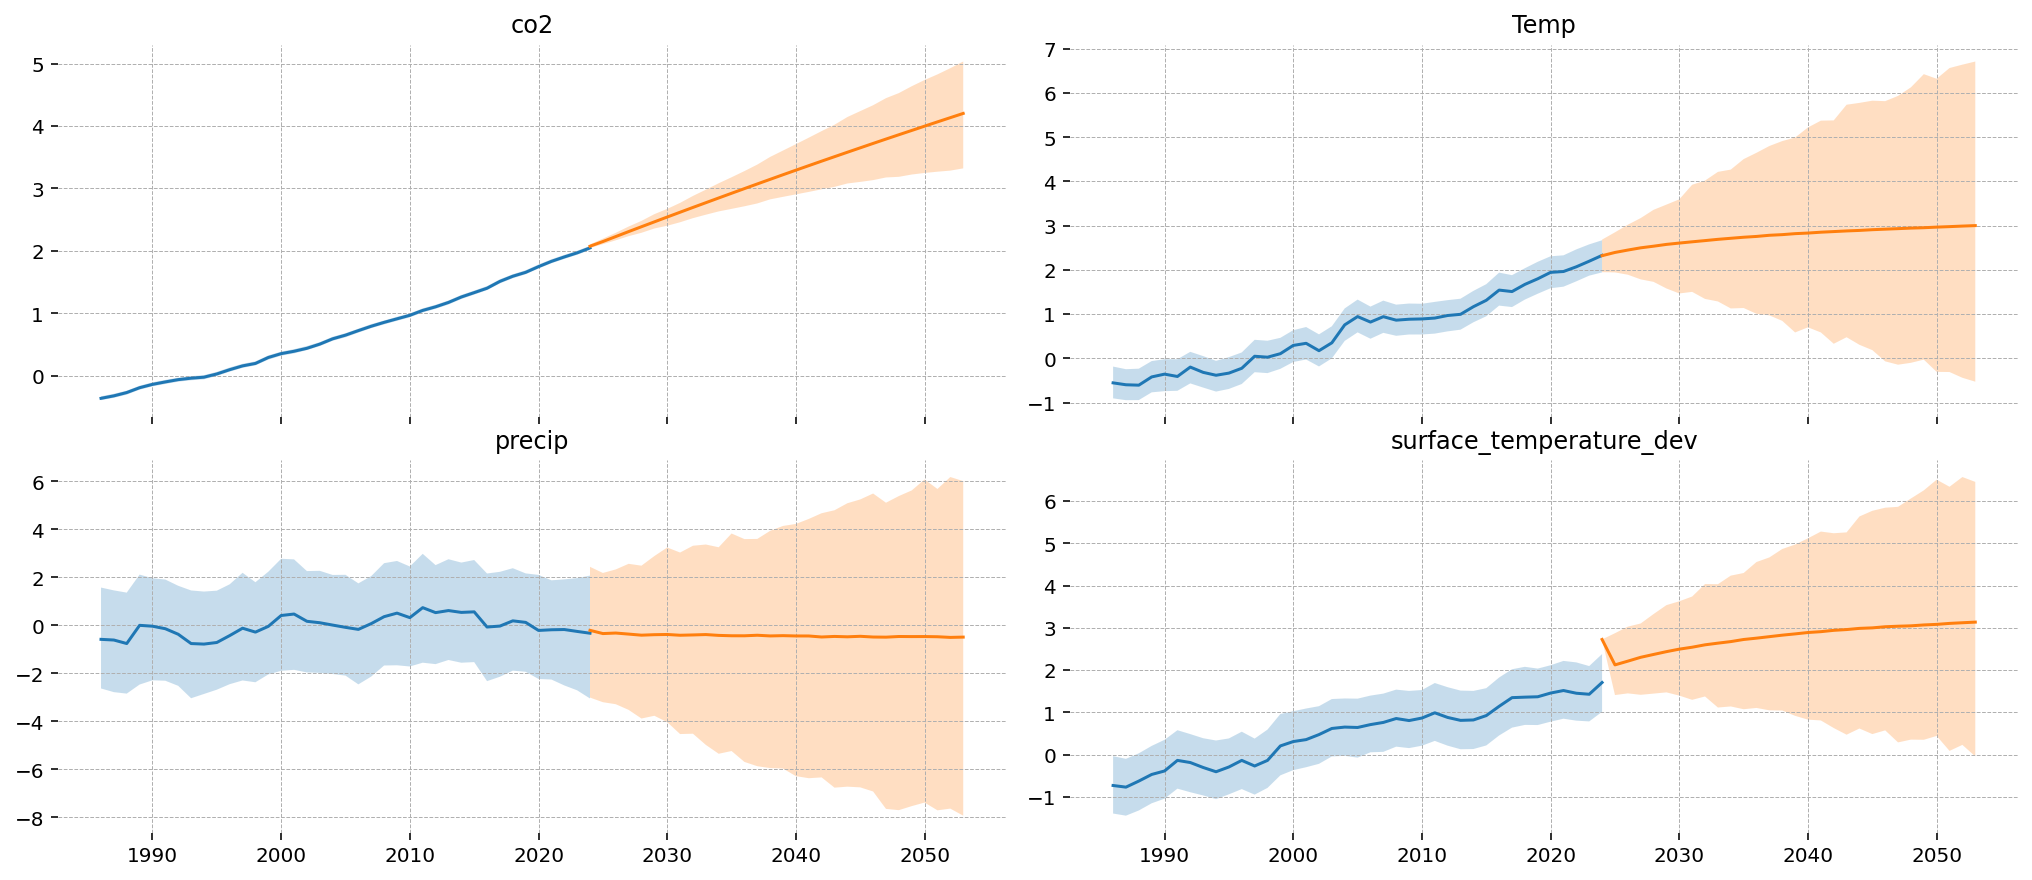

In [13]:
hdi = az.hdi(idata_pred.predicted_posterior_observed).predicted_posterior_observed
mu = idata_pred.predicted_posterior_observed.mean(dim=['chain', 'draw'])

fig, ax = plt.subplots(2, 2, figsize=(14, 6), dpi=144, sharex=True)
plot_slice = slice(30, None)

forecast_x = idata_forecast.forecast_observed.coords['time']
forecast_mu = idata_forecast.forecast_observed.mean(dim=['chain', 'draw'])
forecast_hdi = az.hdi(idata_forecast.forecast_observed).forecast_observed

for axis, name in zip(fig.axes, df.columns):
    axis.plot(df.index[plot_slice], mu.sel(observed_state=name).isel(time=plot_slice))
    axis.fill_between(df.index[plot_slice], *hdi.sel(observed_state=name).isel(time=plot_slice).values.T, alpha=0.25)
    
    axis.plot(forecast_x, forecast_mu.sel(observed_state=name))
    axis.fill_between(forecast_x, 
                      *forecast_hdi.sel(observed_state=name).values.T, alpha=0.25)
    axis.set(title=name)
plt.show()